In [1]:
# Scientific libraries
import numpy as np


%matplotlib notebook
import matplotlib.pyplot as plt
#from jupyterthemes import jtplot
#jtplot.style(context='notebook', fscale=1)


import stan_utility

import pandas as pd


from glob import glob
import copy
import collections
import warnings
warnings.simplefilter('ignore')


import pystan
from vapeplot import vapeplot
from data_generator import DataGenerator
vapeplot.set_palette('vaporwave')

In [36]:
data = pd.read_csv('data_for_fit_f5')

<IPython.core.display.Javascript object>


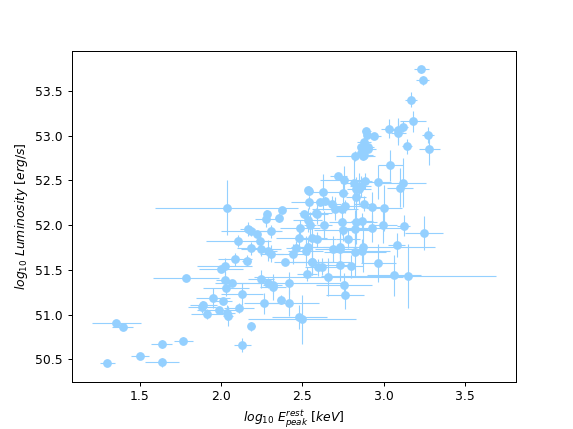

Text(0.5,0,u'$log_{10} \\ E_{peak}^{rest} \\ [keV]$')

In [4]:
fig, ax = plt.subplots()

ax.errorbar(data.ep_obs,
            data.lum_obs,
            xerr = data.ep_err,
            yerr = data.lum_err, marker='o', linewidth=0,elinewidth=0.9)

ax.set_ylabel('$log_{10} \ Luminosity \ [erg/s]$')
ax.set_xlabel('$log_{10} \ E_{peak}^{rest} \ [keV]$')

In [74]:
groups = data.groupby('GRB_name')

In [38]:
singles = []
for name in data.GRB_name.unique():
    grb = groups.get_group(name)
    if len(grb)==1:
        singles.append(name)

In [39]:
singles

['GRB100728439',
 'GRB100816026',
 'GRB120729456',
 'GRB120811649',
 'GRB131011741',
 'GRB100704149',
 'GRB081126899_1',
 'GRB081126899_2',
 'GRB110102788_3',
 'GRB111228657_1']

In [40]:
drop_list = []
for i in range(len(data)):
    for j in range(len(singles)):
        if(data.GRB_name[i]==singles[j]):
            drop_list.append(i)

In [41]:
drop_list

[18, 19, 29, 30, 31, 42, 66, 67, 88, 89]

In [42]:
len(data)

146

In [43]:
data = data.drop(drop_list)

In [44]:
len(data)

136

In [14]:
grb_lengths = []

for name in data.GRB_name.unique():
    grb = groups.get_group(name)    
    grb_lengths.append(len(grb))

In [15]:
N=len(data)
N_grbs = len(grb_lengths)

In [16]:
n_model = 100

In [17]:
data = dict(
            N = N,
            N_grbs = N_grbs,
            grb_length = grb_lengths,
            ep_obs = np.array(data.ep_obs),
            ep_err = np.array(data.ep_err),
            lum_obs = np.array(data.lum_obs),
            lum_err = np.array(data.lum_err),
            N_model = n_model,
            ep_model=np.linspace(.5,3.5,n_model)
        )

In [18]:
pystan.stan_rdump(data,'real.data.R')

        dg = DataGenerator(N_grbs=25, norm_mu=51, norm_sigma=0.5, gamma_mu=1.5, gamma_sigma=0.2)
        dg.generate_sample()
        dg.plot()

        dg.write_data()

In [19]:
data = pystan.read_rdump('real.data.R')

# Read in data

In [20]:
model = stan_utility.compile_model(filename='line_fit.stan')

Using cached StanModel


In [21]:
inits = []

for i in range(4):
        
    g_mu = np.random.uniform(-0.1,0.1)
    g_sig = np.random.uniform(0.15,0.25)
    
    n_mu = np.random.uniform(-0.1,0.1)
    n_sig = np.random.uniform(0.45,0.55)
    
    g_sh = np.random.uniform(1.4,1.6)
    n_sh = np.random.uniform(50.5,51.5)
    
    gamma = np.random.uniform(1.4,1.6,len(data['grb_length']))
    norm = np.random.uniform(50.5,51.5,len(data['grb_length']))
    
    ep = np.random.uniform(1.9,2.1,len(data['ep_obs']))
    l = np.random.uniform(50.5,51.5,len(data['lum_obs']))
    
    
    chain_init = dict(gamma_mu = g_mu,
                      gamma_sigma = g_sig,
                      norm_mu = n_mu,
                      norm_sigma = n_sig,
                      gamma_shift = g_sh,
                      norm_shift = n_sh,
                      gamma = gamma,
                      norm = norm,
                      Ep_latent = ep,
                      L_latent = l)
    
    inits.append(chain_init)

In [22]:
fit = model.sampling(data=data,
                     chains=4,
                     init=inits,
                     iter=2000,
                     thin=1,
                     seed=1244,
                     control=dict(adapt_delta=0.9, max_treedepth=15))

In [23]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat for parameter gamma_true is nan!
  Rhat above 1.1 indicates that the chains very likely have not mixed
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0%)
E-BFMI indicated no pathological behavior


<IPython.core.display.Javascript object>


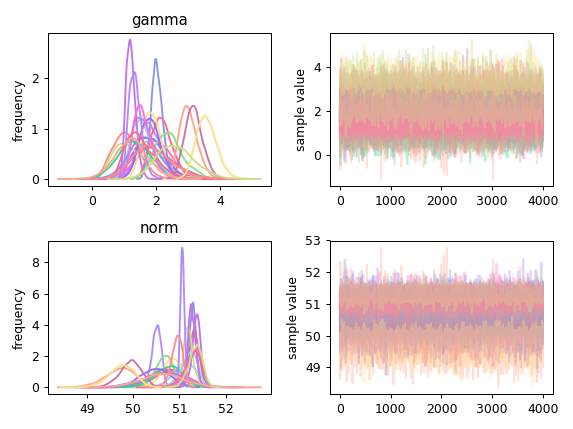

In [75]:
fit.plot(['gamma','norm']);

plt.tight_layout()

<IPython.core.display.Javascript object>


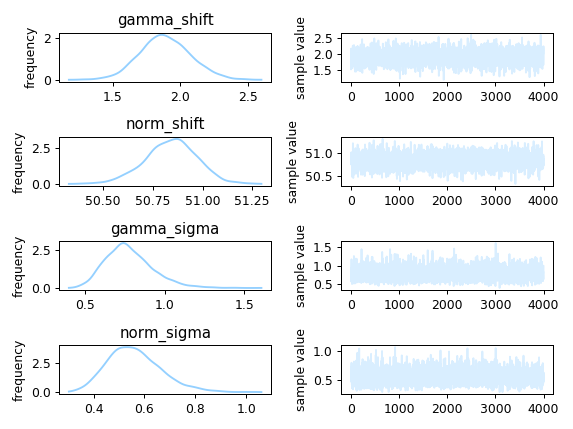

In [76]:
fit.plot(['gamma_shift', 'norm_shift', 'gamma_sigma' ,'norm_sigma' ]);

plt.tight_layout()

In [77]:
# simulation values:

# gamma_shift = 1.5, norm_shift = 51, gamma_sigma = 0.2, norm_sigma = 0.5

g_sh = fit.extract()['gamma_shift']
n_sh = fit.extract()['norm_shift']
g_sig = fit.extract()['gamma_sigma']
n_sig = fit.extract()['norm_sigma']

In [78]:
np.median(g_sh), np.median(n_sh), np.median(g_sig), np.median(n_sig)

(1.8816735024805589,
 50.846199384140675,
 0.7585704854758395,
 0.5518577852223963)

In [79]:
gammas = fit.extract()['gamma']
norms = fit.extract()['norm']
gammas = gammas.T
norms = norms.T

gamma_sh = fit.extract()['gamma_shift']
norm_sh = fit.extract()['norm_shift']
gamma_sig = fit.extract()['gamma_sigma']
norm_sig = fit.extract()['norm_sigma']

ep_latent = fit.extract()['Ep_latent']
lum_latent = fit.extract()['L_latent']
ep_latent = ep_latent.T
lum_latent = lum_latent.T

fitted_lines = fit.extract()['fitted_lines']


In [83]:
fitted_lines.shape

(4000, 26, 100)

In [29]:
fitted_lines = fit.extract()['fitted_lines']

<IPython.core.display.Javascript object>


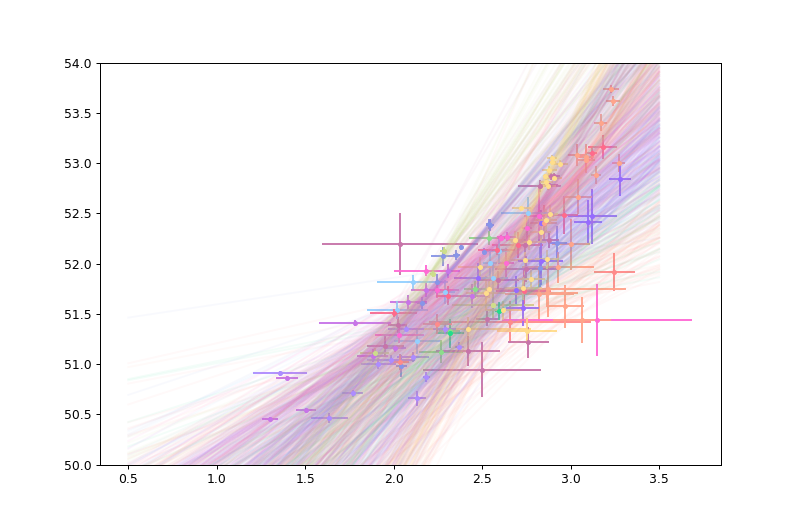

(50, 54)

In [30]:
fig, ax = plt.subplots()

i=0
for n in range(data['N_grbs']):
    
    for y in fitted_lines[::100,n,:]:
        
        cc = (2*vapeplot.palette('vaporwave'))[n]
        
        
        ax.plot(data['ep_model'], y, alpha=0.05,color=cc)


    slice = np.arange(i,i+data['grb_length'][n])
    
    ax.errorbar(data['ep_obs'][slice], data['lum_obs'][slice],
                xerr=data['ep_err'][slice],
                yerr=data['lum_err'][slice],
                
                
                fmt='.',color=cc )

    i += data['grb_length'][n]
    #grb_size.append(idx.sum())

ax.set_ylim(50,54)
    
    
    

<IPython.core.display.Javascript object>


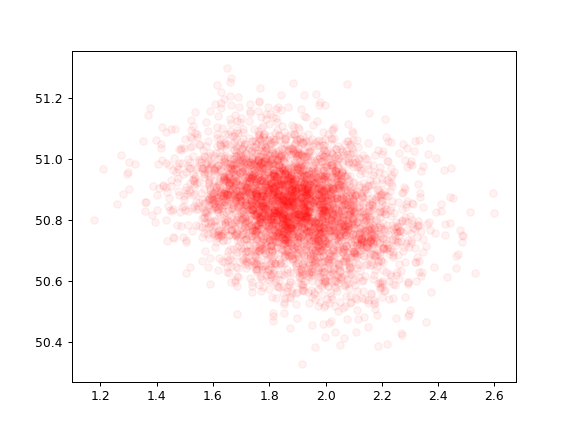

In [34]:
fig, ax = plt.subplots()

ax.scatter(fit.extract()['gamma_shift'], fit.extract()['norm_shift'],alpha=0.05, color='r')